# Implementation of "On event based optical flow detection"

## Glossary:

### 1) Temporal filters

### 2) Spatial filters

### 3) Using filters on an image using combinations of both

In [64]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
# color map to plot
from matplotlib import cm
# processing files
import pandas as pd
# path.join
from os import path

### Terminology

Apothem: Half length of a side of a square

Tau: Another name for $2 \pi$

# Temporal Filters:

Temporal filters are one-dimensional filters composed of unnormalized Gaussian functions.

Monophasic filter is used in combination with spatial-odd Gabor-like filter.

Biphasic filter, composed of two filters, is used in combination with spatial-even Gabor-like filter.

The unnormalized Gaussian function is as following: 

* $\large e^{-\frac{(t - \mu)^2}{2 \sigma^2}}$

## Hyperparameters

Only scale of biphasic filters and mean of the first biphasic filter are hyperparameters in the original paper.

In [65]:
#bi1_mean and scale_bi's are only hyperparameters given in paper
scale_bi1 = -1/2
scale_bi2 = 3/4

bi1_mean = 0.2
bi2_mean = bi1_mean * 2
# - in the scale for positive value
mono_mean = (1 + bi1_mean * np.sqrt(36 + 10 * np.log(-scale_bi1 / scale_bi2))) / 10
# 3 sigma rule for bi1 and mono
bi1_sigma = bi1_mean / 3
bi2_sigma = bi1_sigma * (3/2)
mono_sigma = mono_mean / 3

In [66]:
class TemporalFilter:
    def __init__(self, mu, sigma):
        self.mu = mu
        # Optimized (not necessarily needed)
        self.exponent_multiplier = -1 / (2 * sigma**2)
        
    def get(self, time):
        time_diff = (self.mu - time)**2
        exponent_value = np.exp(time_diff * self.exponent_multiplier)

        return exponent_value

Setting the matplotlib.

In [67]:
# for opening inside notebook
%matplotlib inline 
# for opening in another window
# %matplotlib qt

Outputting the results of filters.

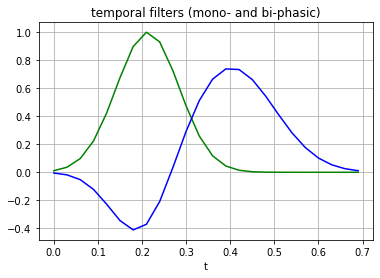

In [68]:
output_dir = "Outputs"

t = np.arange(0.0, 0.7, 0.03)  # 0.7 as the filters becomes close to zero near it
temporal_mono_filter = TemporalFilter(mono_mean, mono_sigma)
temporal_bi1_filter = TemporalFilter(bi1_mean, bi1_sigma)
temporal_bi2_filter = TemporalFilter(bi2_mean, bi2_sigma)
t_mono = temporal_mono_filter.get(t)
t_bi = scale_bi1 * temporal_bi1_filter.get(t)
t_bi += scale_bi2 * temporal_bi2_filter.get(t)

fig2, ax1 = plt.subplots()
ax1.plot(t, t_mono, "g-")
ax1.plot(t, t_bi, "b-")
ax1.set_title("temporal filters (mono- and bi-phasic)")
ax1.set_xlabel("t")
plt.savefig(path.join(output_dir, "temporal_filters_mono_bi.png"))
plt.grid()
plt.show()

# Spatial Gabor-like Filters

Spatial Gabor-like filters are two dimensional filters responsible for processing events on image coordinates.

By definition of the filters, the output is maximized when it is oriented towards a certain angle.

The first component that is common to both even and odd is taken as:

* $\large e^{-\frac{2 \pi^2 (x'^{2} + y'^{2})}{\sigma^2}}$

While the second component is, for even:

* $\cos 2 \pi (f^0_x  x' + f^0_y y')$

and for odd

* $\sin 2 \pi (f^0_x x' + f^0_y y')$

## Hyperparameters

$f^{0}_{x}, f^{0}_y$, $\sigma$ are hyperparameters per paper.

In [69]:
f0x = 0.057
f0y = f0x

scale_amount = 1

#### Generating one filter

In [70]:
tau = np.pi * 2  # apparently there is a name for 2*pi

def spatial_gabor_filter_even(x, y, sigma, theta, f0x, f0y):
    # rotation and appending is needed for x, y axes
    theta = -theta
    theta -= np.pi / 4
    
    x_hat = np.cos(theta) * x + np.sin(theta) * y
    y_hat = -np.sin(theta) * x + np.cos(theta) * y

    gabor_first = np.exp(-1 * ((x_hat)**2 + (y_hat)**2) * (2 * np.pi**2) / sigma**2)
    gabor_second = np.cos(tau * (f0x * x_hat + f0y * y_hat))
    gabor_even = (tau / sigma**2) * gabor_first * gabor_second

    return gabor_even


def spatial_gabor_filter_odd(x, y, sigma, theta, f0x, f0y):
    # rotation and appending is needed for x, y axes
    theta = -theta
    theta -= np.pi / 4
    
    x_hat = np.cos(theta) * x + np.sin(theta) * y
    y_hat = -np.sin(theta) * x + np.cos(theta) * y

    
    gabor_first = np.exp(-1 * ((x_hat)**2 + (y_hat)**2) * (2 * np.pi**2 / sigma**2))
    gabor_second = np.sin(tau * (f0x * x_hat + f0y * y_hat))
    gabor_odd = (tau / sigma**2) * gabor_first * gabor_second

    return gabor_odd

#### Quick function for generating certain amount of filters.

##### Note: Only using $f^0_x$ for now.

In [71]:
def generate_spatial_filters(filter_amount, filter_apothem, spatial_sigma, f0x, f0y):
    spatial_even_filters = list()
    spatial_odd_filters = list()
    
    filter_range = np.arange(-filter_apothem, filter_apothem+1)  #  may be optimized (no minus part) by direction / sign change
    # order is reversed for sensor_height - width for x, y indexing as in a picture
    filter_width_range, filter_height_range = np.meshgrid(filter_range, filter_range, indexing="xy")

    for i in range(filter_amount):
        angle = tau * i / filter_amount
        gabor_even = spatial_gabor_filter_even(filter_width_range, filter_height_range, spatial_sigma, angle, f0x, f0x)
        gabor_odd = spatial_gabor_filter_odd(filter_width_range, filter_height_range, spatial_sigma, angle, f0x, f0x)

        spatial_even_filters.append(gabor_even)
        spatial_odd_filters.append(gabor_odd)
    
    return spatial_even_filters, spatial_odd_filters

#### Outputting the filters.

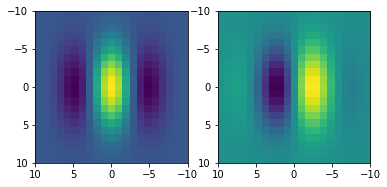

In [72]:
filter_amount = 32
filter_apothem = 10
spatial_sigma = 25

filter_size = filter_apothem * 2 + 1

spatial_even_filters, spatial_odd_filters = \
    generate_spatial_filters(filter_amount, filter_apothem, spatial_sigma, f0x, f0x)

G_even = spatial_even_filters[0]
G_odd = spatial_odd_filters[0]
fig = plt.figure()
axis_extend = [filter_apothem, -filter_apothem, filter_apothem, -filter_apothem]
plt.subplot(1, 2, 1), plt.imshow(G_even, extent=axis_extend)
plt.subplot(1, 2, 2), plt.imshow(G_odd, extent=axis_extend)
plt.savefig(path.join(output_dir, "spatial_filters_1.png"))
# Note: Shows neuron's response, not the filter itself.

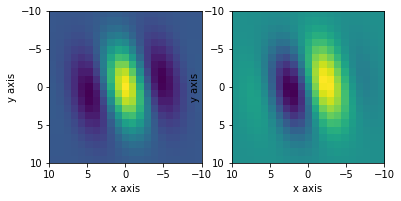

In [73]:
G_even = spatial_even_filters[1]
G_odd = spatial_odd_filters[1]
fig = plt.figure()
plt.subplot(1, 2, 1), plt.xlabel("x axis"), plt.ylabel("y axis")
plt.imshow(G_even, extent=axis_extend)
plt.subplot(1, 2, 2), plt.xlabel("x axis"), plt.ylabel("y axis"),
plt.imshow(G_odd, extent=axis_extend)
plt.savefig(path.join(output_dir, "spatial_filters_2.png"))

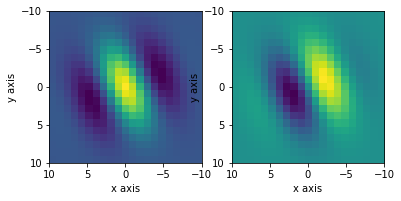

In [74]:
G_even = spatial_even_filters[2]
G_odd = spatial_odd_filters[2]
fig = plt.figure()
plt.subplot(1, 2, 1), plt.xlabel("x axis"), plt.ylabel("y axis")
plt.imshow(G_even, extent=axis_extend)
plt.subplot(1, 2, 2), plt.xlabel("x axis"), plt.ylabel("y axis")
plt.imshow(G_odd, extent=axis_extend)
plt.savefig(path.join(output_dir, "spatial_filters_3.png"))

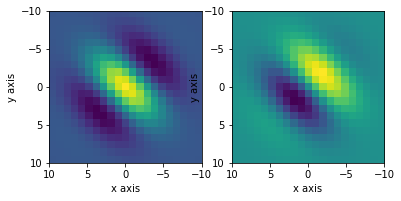

In [75]:
G_even = spatial_even_filters[4]
G_odd = spatial_odd_filters[4]
fig = plt.figure()
plt.subplot(1, 2, 1), plt.xlabel("x axis"), plt.ylabel("y axis")
plt.imshow(G_even, extent=axis_extend)
plt.subplot(1, 2, 2), plt.xlabel("x axis"), plt.ylabel("y axis")
plt.imshow(G_odd, extent=axis_extend)
plt.savefig(path.join(output_dir, "spatial_filters_4.png"))

#### See filters in 3D plot where y axis is the value of filter's response.

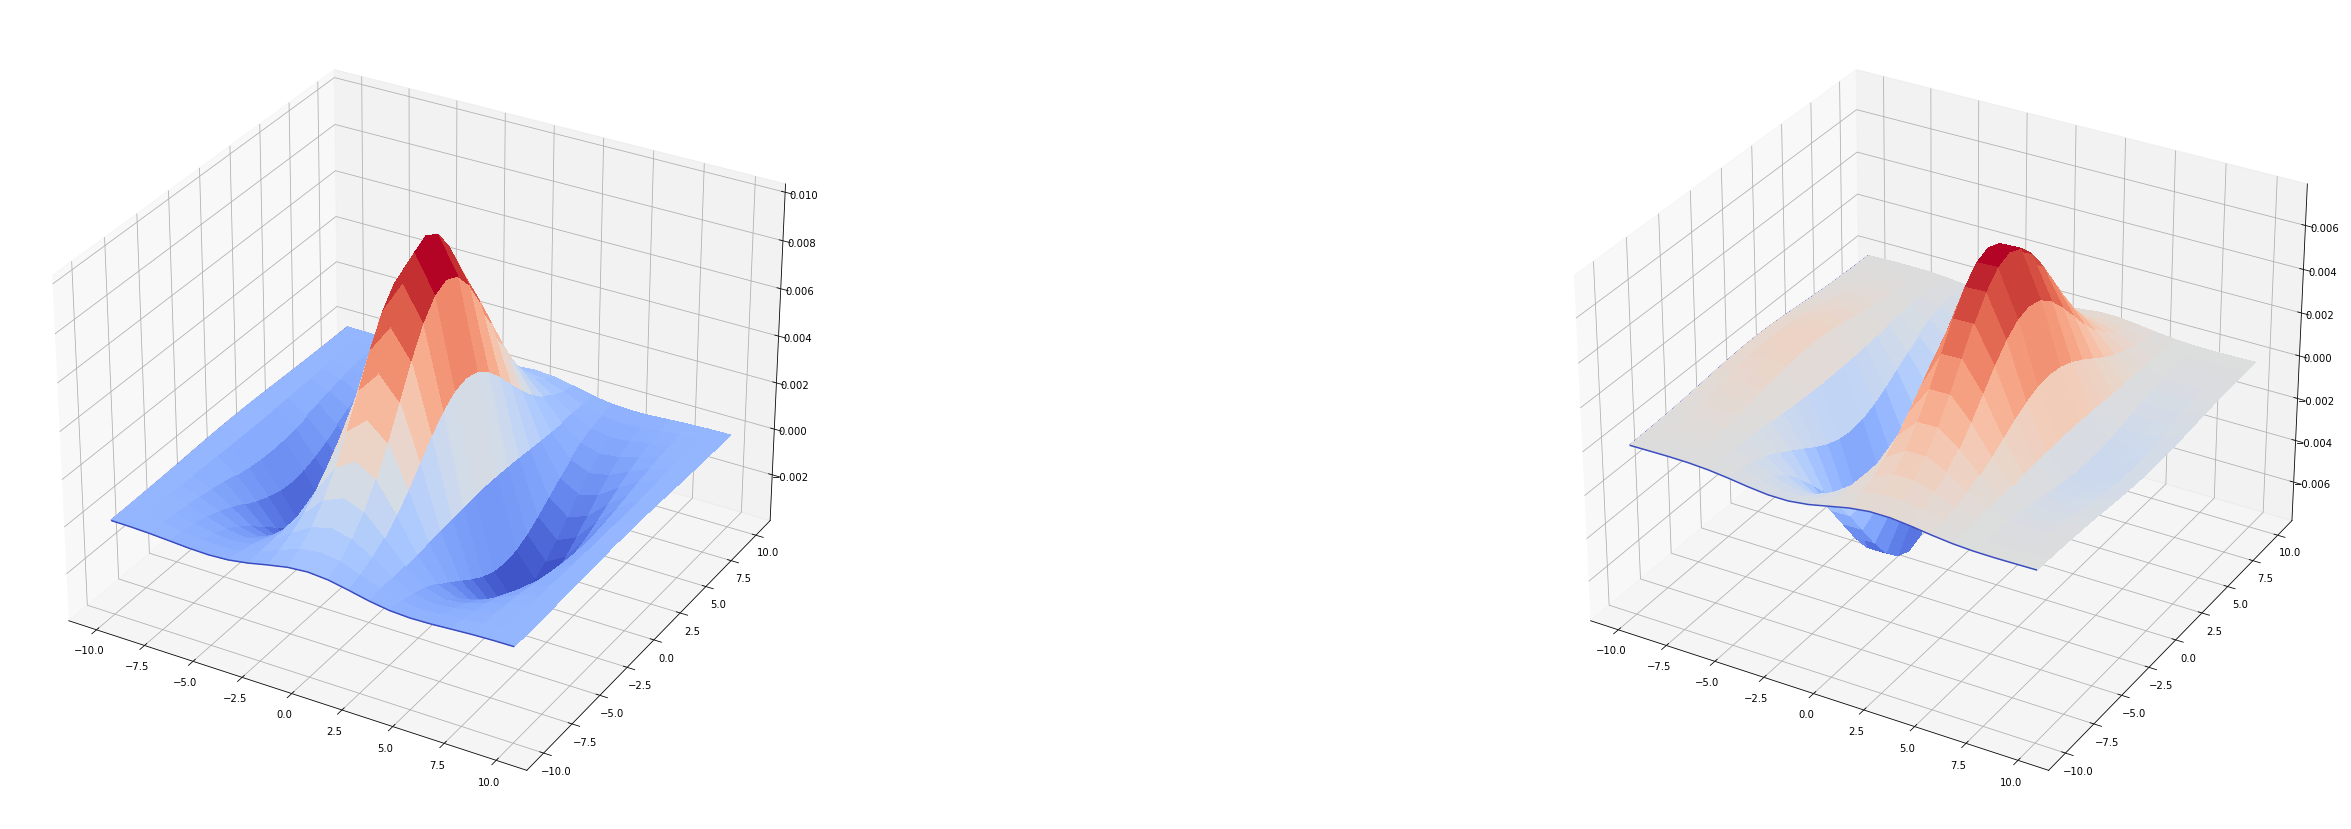

In [76]:
fig = plt.figure(figsize=(50, 15))

val_range = np.arange(-filter_apothem, filter_apothem+1)
X, Y = np.meshgrid(val_range, val_range)

show_filters = 1
nrows = 1

for filter_ in range(show_filters):
    ev_filter = spatial_even_filters[filter_]
    odd_filter = spatial_odd_filters[filter_]
    ax = fig.add_subplot(nrows, 2 * math.ceil(show_filters / nrows), filter_ * 2 + 1, projection="3d")    
    ax.plot_surface(X, Y, ev_filter, rstride=1, cstride=1, cmap=cm.coolwarm, \
                    linewidth=0, antialiased=False)
    # ax.plot_surface(X, Y, Z, rstride=4, cstride=4, alpha=0.25)
    ax.contour(X, Y, ev_filter, zdir="z", cmap=cm.coolwarm)
    ax.contour(X, Y, ev_filter, zdir="x", cmap=cm.coolwarm)
    ax.contour(X, Y, ev_filter, zdir="y", cmap=cm.coolwarm)
    
    ax = fig.add_subplot(nrows, 2 * math.ceil(show_filters / nrows), filter_ * 2 + 2, projection="3d")    
    ax.plot_surface(X, Y, odd_filter, rstride=1, cstride=1, cmap=cm.coolwarm, \
                    linewidth=0, antialiased=False)
    # ax.plot_surface(X, Y, Z, rstride=4, cstride=4, alpha=0.25)
    ax.contour(X, Y, odd_filter, zdir="z", cmap=cm.coolwarm)
    ax.contour(X, Y, odd_filter, zdir="x", cmap=cm.coolwarm)
    ax.contour(X, Y, odd_filter, zdir="y", cmap=cm.coolwarm)
    
    # cb = fig.colorbar(p, shrink=0.5)
#     ax.set_title(" filter bank " + str(i) + "/8 pi")
#     ax.set_zlabel("Z", fontdict={"size": 15, "color": "red"})
#     ax.set_ylabel("Y", fontdict={"size": 15, "color": "red"})
#     ax.set_xlabel("X", fontdict={"size": 15, "color": "red"})

plt.savefig(path.join(output_dir, "spatial_3d.png"))
plt.show()

#### Show filter's response for certain x value.

In [77]:
space_time_filters = []
filters_to_pi = filter_amount // 2
for i in range(filters_to_pi):
    G_even = spatial_even_filters[i]
    G_odd = spatial_odd_filters[i]
    space_time_kernel = G_even[:, :, None] * t_bi + G_odd[:, :, None] * t_mono
    space_time_filters.append(space_time_kernel)

<Figure size 432x288 with 0 Axes>

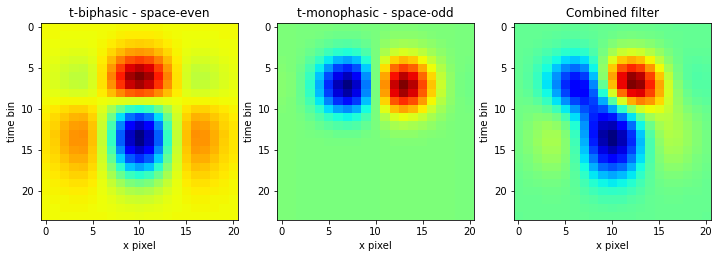

In [78]:
# Plot an x-t slice of each component of the space-time filter
# Fig 3 in the 2014 paper
slice_idx = filter_apothem  # index of the central y-slice, transposed

fig = plt.figure()
plt.figure(figsize=(12,12))

num_bins_t = len(t_mono)

filter_index = 4
space_time_kernel_even = spatial_even_filters[filter_index][:, :, None] * t_bi
space_time_kernel_odd = spatial_odd_filters[filter_index][:, :, None] * t_mono
space_time_kernel_sum = space_time_kernel_even + space_time_kernel_odd

sliced_st_even = space_time_kernel_even[:, slice_idx, :]
sliced_st_odd = space_time_kernel_odd[:, slice_idx, :]
sliced_st_sum = space_time_kernel_sum[:, slice_idx, :]


plt.subplot(1, 3, 1)

set_aspect_val = filter_size / num_bins_t

plt.imshow(np.transpose(sliced_st_even), cmap='jet_r')
#plt.gca().invert_yaxis()
plt.gca().set_aspect(set_aspect_val)
plt.xlabel("x pixel"), plt.ylabel("time bin"), plt.title("t-biphasic - space-even")
plt.subplot(1, 3, 2),
plt.imshow(np.transpose(sliced_st_odd), cmap='jet_r')
plt.gca().set_aspect(set_aspect_val)
plt.xlabel("x pixel"), plt.ylabel("time bin"), plt.title("t-monophasic - space-odd")
plt.subplot(1, 3, 3),
plt.imshow(np.transpose(sliced_st_sum), cmap='jet_r')
plt.gca().set_aspect(set_aspect_val)
plt.xlabel("x pixel"), plt.ylabel("time bin"), plt.title("Combined filter")
plt.savefig(path.join(output_dir, "even_odd_combined.png"))

<Figure size 432x288 with 0 Axes>

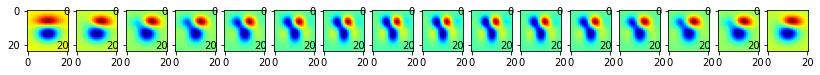

In [79]:
# Show filters
fig = plt.figure()
plt.figure(figsize=(14,14))
num_filters = len(space_time_filters)
# print(filters[0][:,5,:])
for i in range(num_filters):
    plt.subplot(1,num_filters, i+1),
    plt.imshow(np.transpose(space_time_filters[i][:,slice_idx,:]), cmap='jet_r')
    #plt.gca().invert_yaxis()
    plt.gca().set_aspect( (filter_size / num_bins_t) )

In [80]:
plt.savefig(path.join(output_dir, "spacetime_filters.png"))

<Figure size 432x288 with 0 Axes>

## Implementation

In [81]:
def get_filtered_image(event_subset, t_end,
                       start_x_img, start_y_img, stop_x_img, stop_y_img, 
                       filter_amount, temporal_mono_filter, 
                       temporal_bi1_filter, temporal_bi2_filter,
                       scale_biphasic1, scale_biphasic2,
                       spatial_even_filters, spatial_odd_filters
                      ):
       
    pixels_x = stop_x_img - start_x_img
    pixels_y = stop_y_img - start_y_img
    
    stop_index = len(event_subset)
    # order is reversed for sensor_height - width for x, y indexing as in a picture
    image_phasic = np.zeros((2, pixels_y, pixels_x), dtype=np.float64)
    
    for index in np.arange(0, stop_index):
        t, x, y = event_subset[index]

        # Compute temporal filter

        t_diff = t_end - t

        # Start with even_filter's component, biphasic. Plus 0 is even
        image_phasic[0, y, x] += scale_biphasic1 * temporal_bi1_filter.get(t_diff) + \
            scale_biphasic2 * temporal_bi2_filter.get(t_diff)
        image_phasic[1, y, x] += temporal_mono_filter.get(t_diff)
    
    
    filtered_image = np.zeros((filter_amount, pixels_y, pixels_x), dtype=np.float64)

    for i in range(filter_amount):
        filtered_image[i] = cv2.filter2D(image_phasic[0], -1, spatial_even_filters[i], borderType=cv2.BORDER_ISOLATED)
        filtered_image[i] += cv2.filter2D(image_phasic[1], -1, spatial_odd_filters[i], borderType=cv2.BORDER_ISOLATED)        
        
    return filtered_image

In [82]:
def load_events(path_to_events):
    event_list = pd.read_csv(path_to_events, delim_whitespace=True, header=None,
                          names=['t', 'x', 'y', 'p'],
                          dtype={'t': np.float64, 'x': np.int16, 'y': np.int16, 'p': np.int8},
                          engine='c', nrows=None, memory_map=True)
    # no polarity needed
    event_list = event_list.drop(columns=['p'])
    event_list = event_list.to_records(index=False)

    # First row: time, x, y
    time_start = event_list[0][0]
    time_end = event_list[len(event_list)-1][0]

    print("Loaded {:.2f}M events.".format(len(event_list) / 1e6))
    print("Time between: {} and {}.".format(time_start, time_end))
    
    return event_list

In [83]:
path_to_events = '../slider_far/events_fast_drone.txt'
event_list = load_events(path_to_events)

Loaded 0.30M events.
Time between: 1519939777.7220104 and 1519939778.7220004.


#### Create event subset suitable for the complete first response.

In [84]:
# Temporal filters become 0 when t_diff > 0.07
# So we can get a period that uses such
t_diff = 0.7

t_start = event_list[0][0]
t_end = t_start + t_diff


start_ind = 0 # replace with searchsorted left if not 0
stop_ind = np.searchsorted(event_list['t'], t_end, "left")

event_subset = event_list[start_ind:stop_ind]
print("Number of events: {}".format(stop_ind))
print("Time interval: {} : {}".format(t_start, t_end))

Number of events: 268301
Time interval: 1519939777.7220104 : 1519939778.4220104


#### Set camera resolution and filter amount before processing.

In [85]:
# DAVIS camera pixel resolution
sensor_width = 240
sensor_height = 180

filter_amount = 4
spatial_even_filters, spatial_odd_filters = \
    generate_spatial_filters(filter_amount, filter_apothem, spatial_sigma, f0x, f0x)

In [86]:
%%time
filtered_image = get_filtered_image(event_subset, t_end,
                              0, 0, sensor_width, sensor_height,
                              filter_amount, temporal_mono_filter, 
                              temporal_bi1_filter, temporal_bi2_filter,
                              scale_bi1, scale_bi2,
                              spatial_even_filters, spatial_odd_filters)

Wall time: 3.05 s


#### Sum all filter responses into one image 

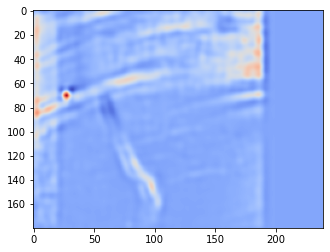

In [87]:
res = np.sum(filtered_image, axis=0)
plt.imshow(res, cmap=cm.coolwarm)
plt.savefig(path.join(output_dir, "res.png"))

#### Show individual filter responses.

<Figure size 432x288 with 0 Axes>

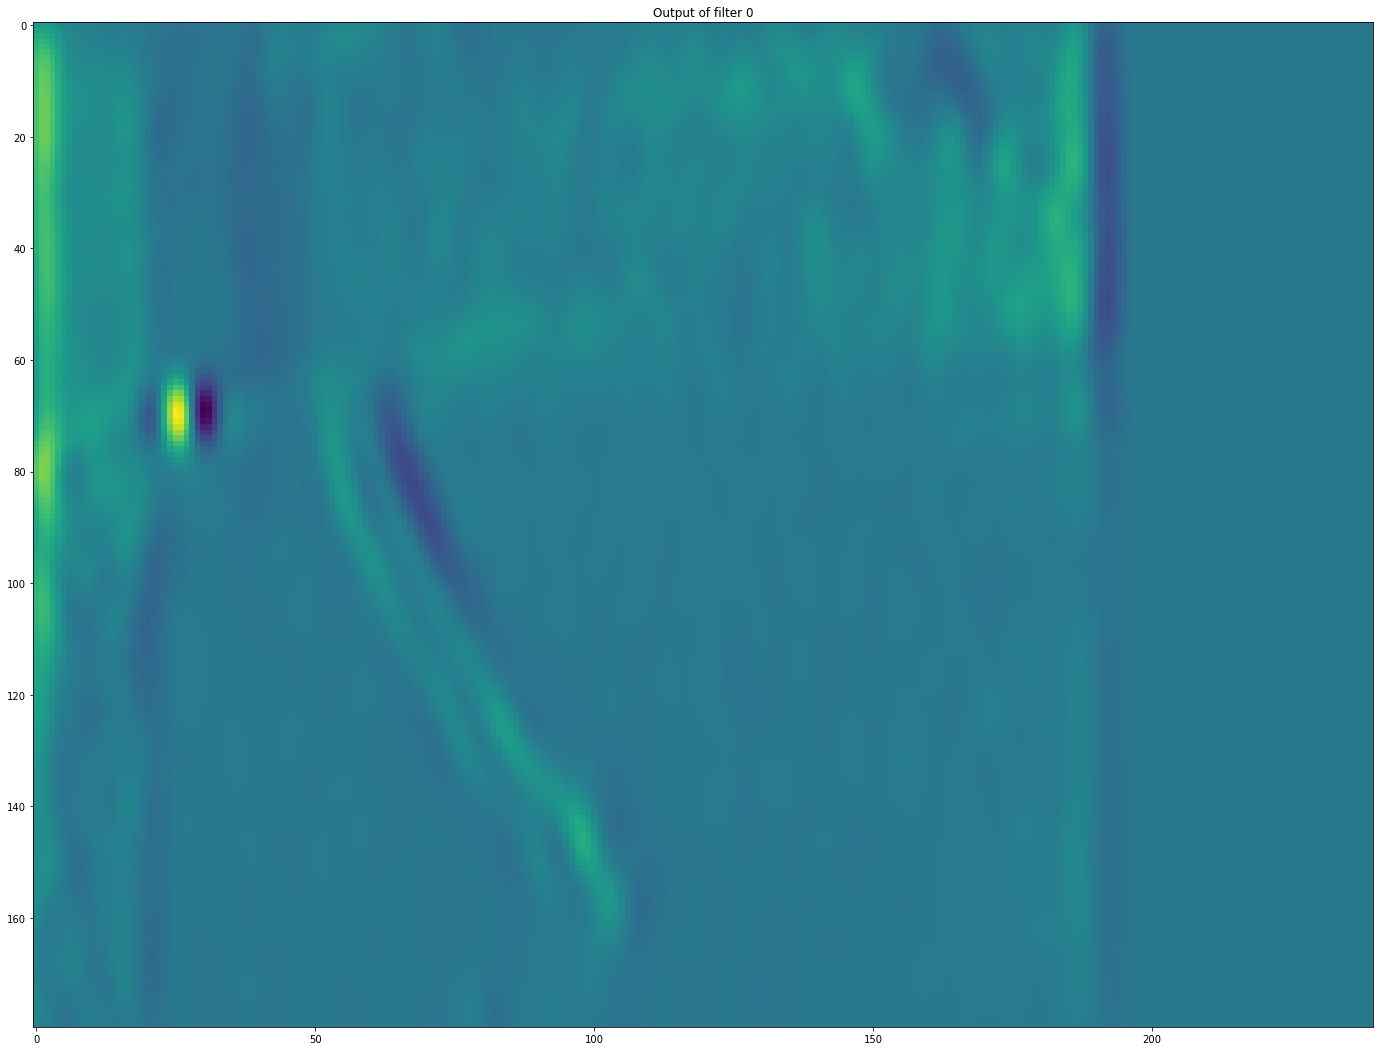

In [88]:
# Visualize results
fig = plt.figure()
plt.figure(figsize=(24, 24))

filters_to_show = filter_amount // 4

for i in range(filters_to_show):
    plt.subplot(1, filters_to_show, i+1)
    plt.imshow(filtered_image[i])
    plt.title("Output of filter " + str(i))

#### Vectorize the filter responses to output total response and direction.

In [89]:
def filter_vectors(filtered_image, filter_amount):
    # can also eigensum.
    pixels_y, pixels_x = filtered_image.shape[1:]
    u = np.zeros((pixels_y, pixels_x), dtype=np.float64)
    v = np.zeros((pixels_y, pixels_x), dtype=np.float64)
    for k in range(filter_amount):
        # there is no minus in sin, which I think is correct.
        # this is due to -theta in filter.
        u = u + np.cos(tau * k / filter_amount) * filtered_image[k]
        v = v + np.sin(tau * k / filter_amount) * filtered_image[k]
    return u, v

In [90]:
u, v = filter_vectors(filtered_image, filter_amount)

#### Show the responses with quivers.

In [91]:
def quiver_show_subset(u, v, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop):
    u_subspace = u[y_subspace_start:y_subspace_stop, x_subspace_start:x_subspace_stop]
    v_subspace = v[y_subspace_start:y_subspace_stop, x_subspace_start:x_subspace_stop]
    
    x_subspace = np.arange(x_subspace_start, x_subspace_stop)
    y_subspace = np.arange(y_subspace_start, y_subspace_stop)
    x_subspace, y_subspace = np.meshgrid(x_subspace, y_subspace)
    
    fig = plt.figure(figsize=(24, 18))
    plt.gca().invert_yaxis()
    plt.xticks(np.arange(x_subspace_start, x_subspace_stop, 5))
    plt.yticks(np.arange(y_subspace_start, y_subspace_stop, 5))
    plt.quiver(x_subspace, y_subspace, u_subspace, v_subspace, color="r")

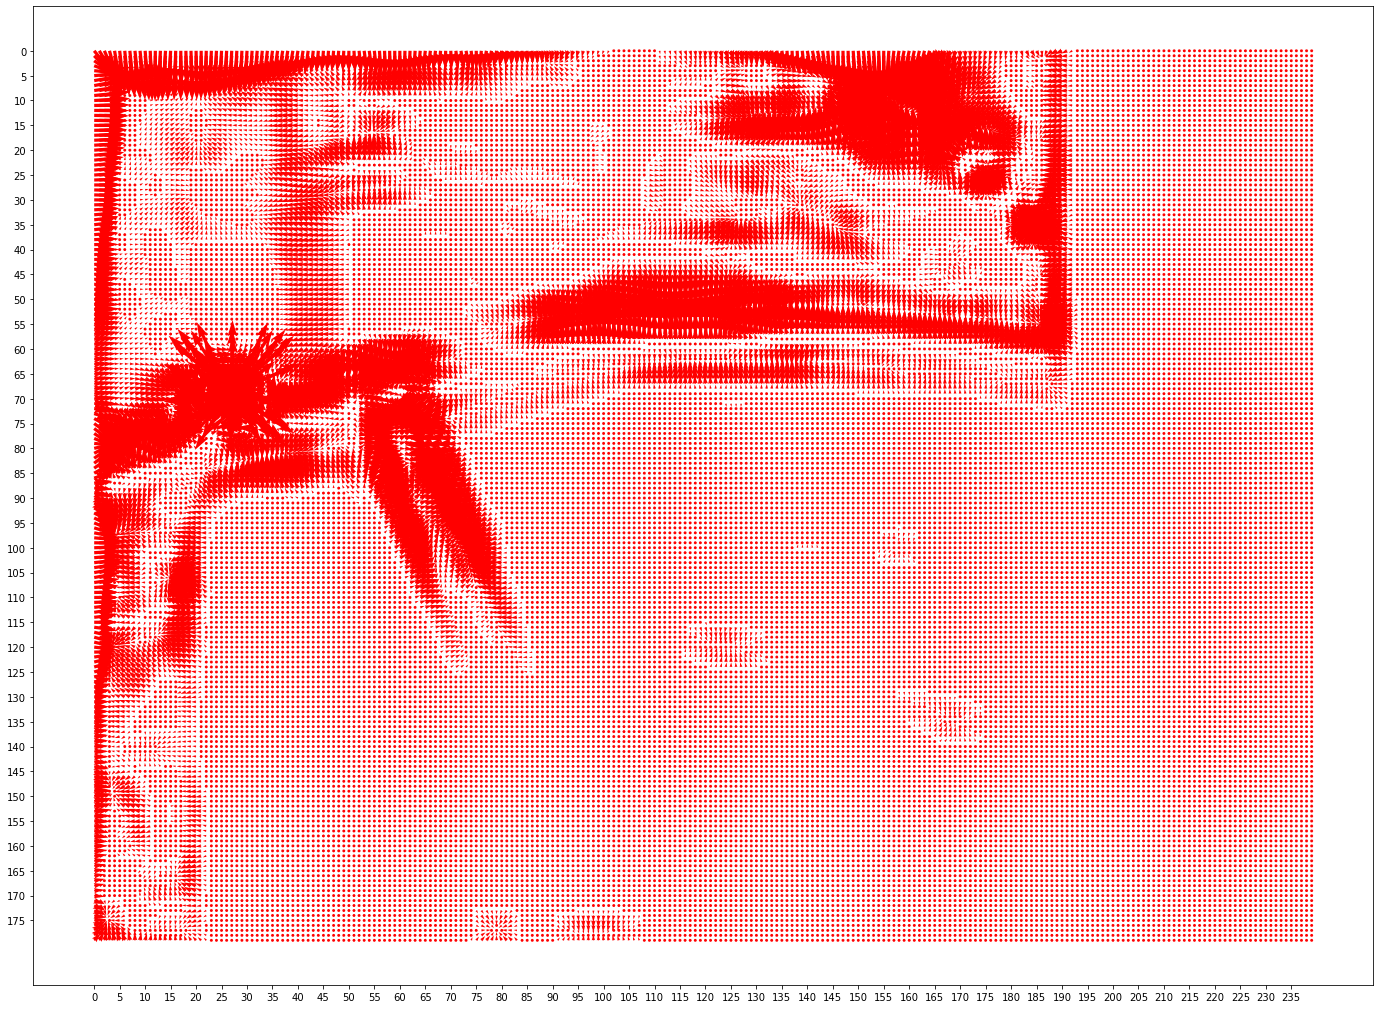

In [92]:
quiver_show_subset(u, v, 0, sensor_width, 0, sensor_height)
plt.savefig(path.join(output_dir, "whole_image.png"))
plt.show()

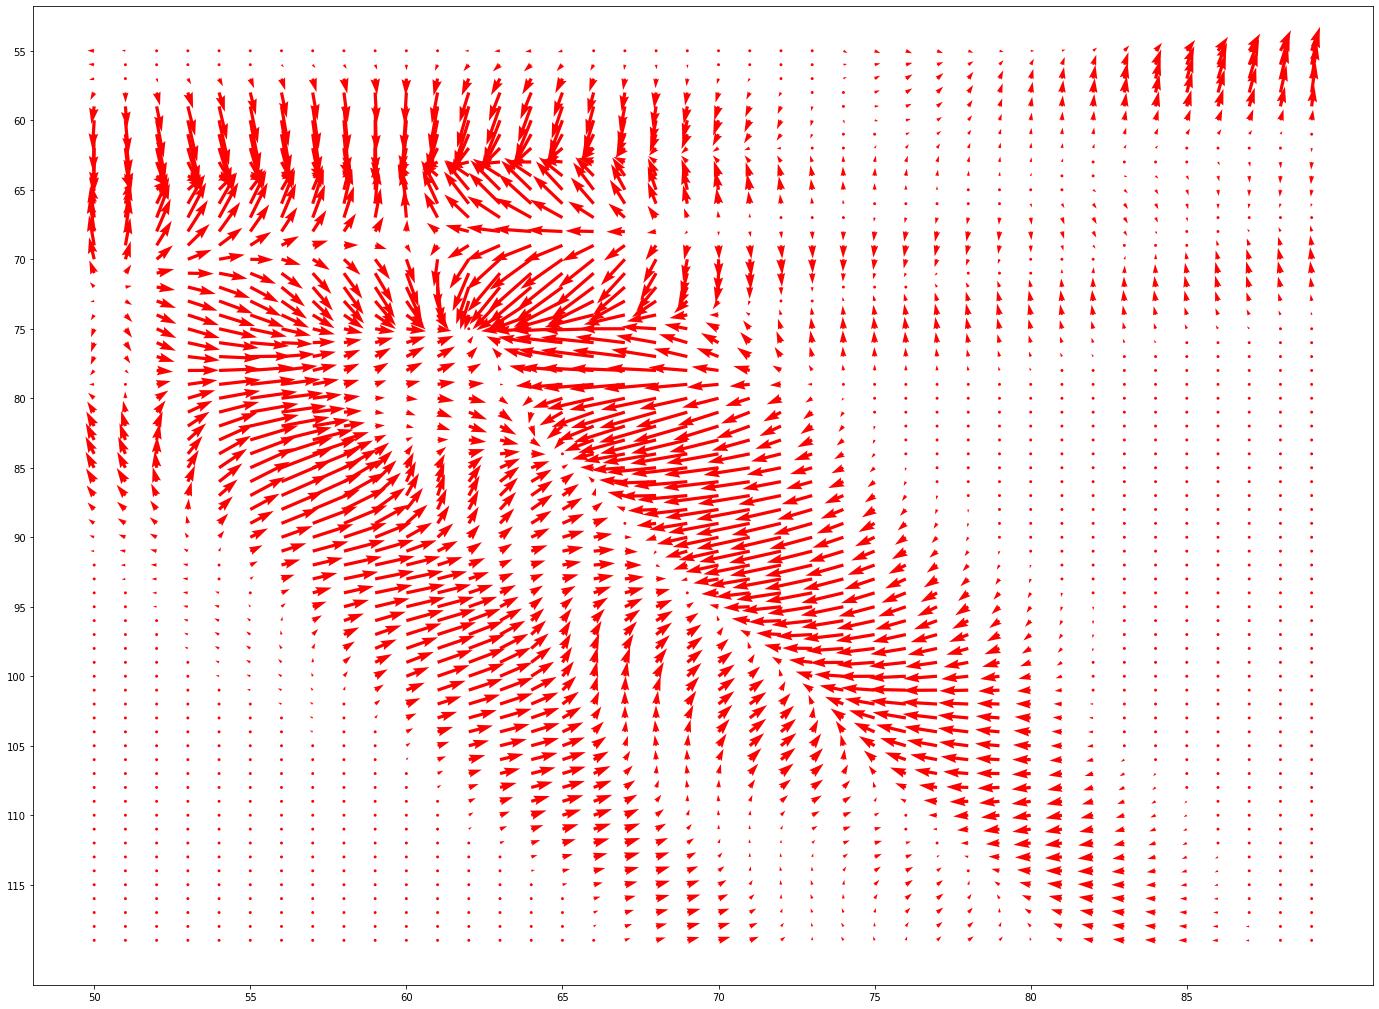

In [93]:
x_subspace_start = 50
x_subspace_stop = 90
y_subspace_start = 55
y_subspace_stop = 120

quiver_show_subset(u, v, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
plt.savefig(path.join(output_dir, "partial_image.png"))
plt.show()

In [94]:
print(np.sum(u[x_subspace_start:x_subspace_stop]), np.sum(v[y_subspace_start:y_subspace_stop]))

-91.02494020447313 827.0144164839385


#### Collecting responses all over image to negate the aperture problem.

##### Note: May not work without normalization. Unoptimized but not necessary.

In [95]:
t_start = event_list[0][0]
t_amount = 6
t_iter = 0.1
t_interval = 0.7

t_start_range = np.arange(t_amount) * t_iter + t_start
t_end_range = t_start_range + t_interval

start_inds = np.searchsorted(event_list['t'], t_start_range, "left")
stop_inds = np.searchsorted(event_list['t'], t_end_range, "right")

filtered_images = np.empty((t_amount, filter_amount, sensor_height, sensor_width))

for index in range(t_amount):
    event_subset_time = event_list[start_inds[index]:stop_inds[index]]
    filtered_images[index] = get_filtered_image(event_subset_time, t_end_range[index],
                                  0, 0, sensor_width, sensor_height,
                                  filter_amount, temporal_mono_filter, 
                                  temporal_bi1_filter, temporal_bi2_filter,
                                  scale_bi1, scale_bi2,
                                  spatial_even_filters, spatial_odd_filters)

In [96]:
# filter_response_sum = np.sum(filtered_images, axis=0)
# u_total, v_total = filter_vectors(filter_response_sum, filter_amount)

u_list = np.empty((t_amount, sensor_height, sensor_width))
v_list = np.empty((t_amount, sensor_height, sensor_width))
for i in range(t_amount):
    u_total, v_total = filter_vectors(filtered_images[i], filter_amount)
    u_list[i] = u_total
    v_list[i] = v_total

#### Whole image over time.

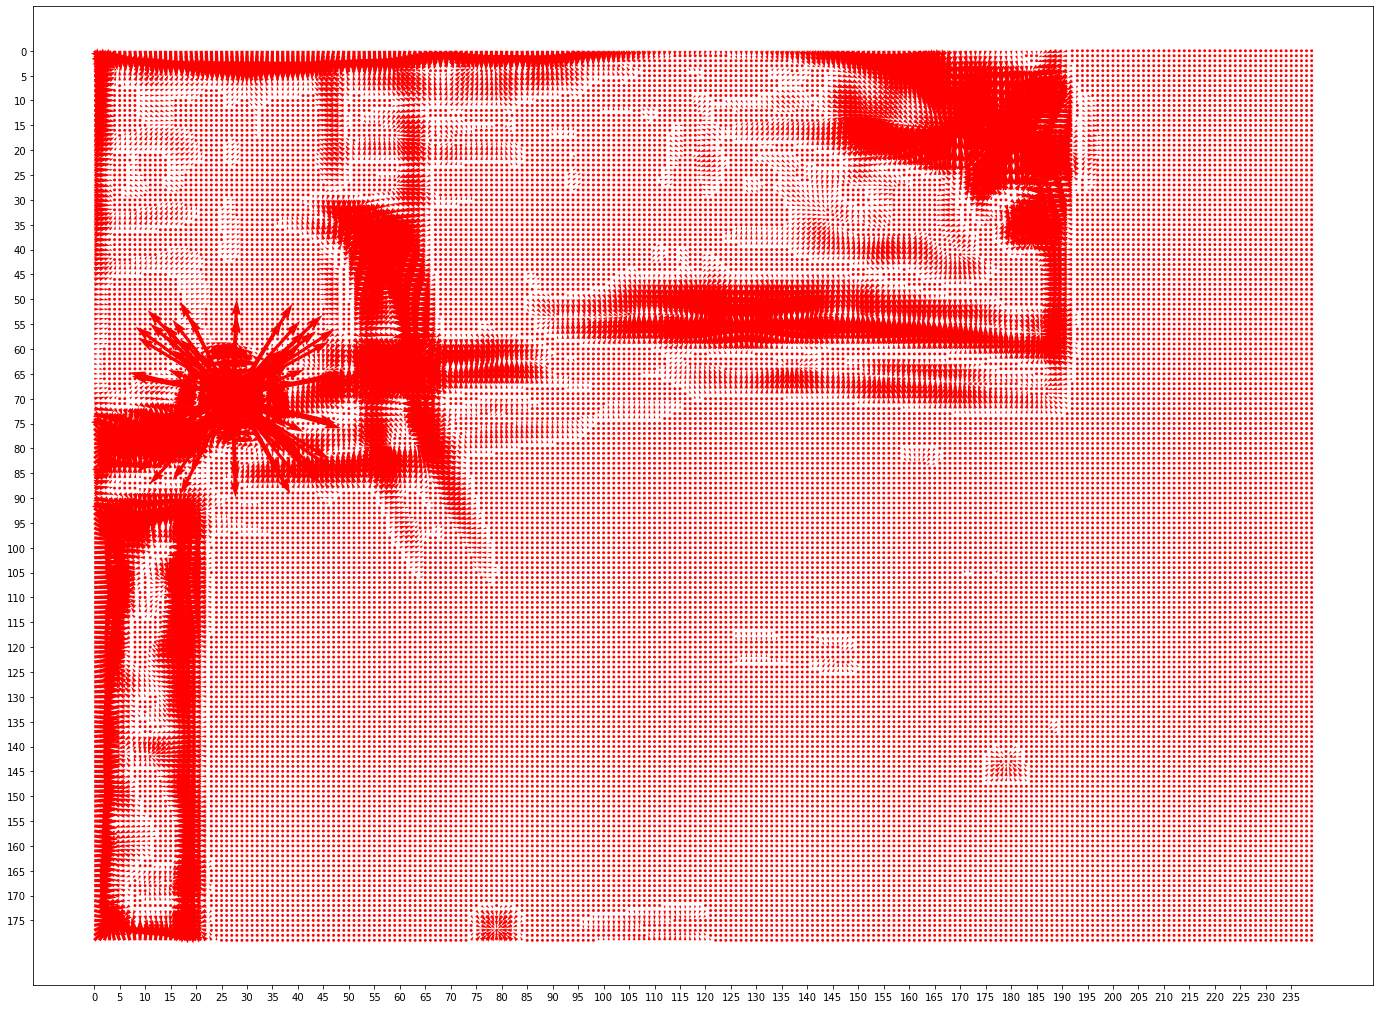

In [97]:
u_total = np.sum(u_list, axis=0)
v_total = np.sum(v_list, axis=0)

quiver_show_subset(u_total, v_total, 0, sensor_width, 0, sensor_height)
plt.savefig(path.join(output_dir, "whole_image_over_time.png"))

#### Partial image over time.

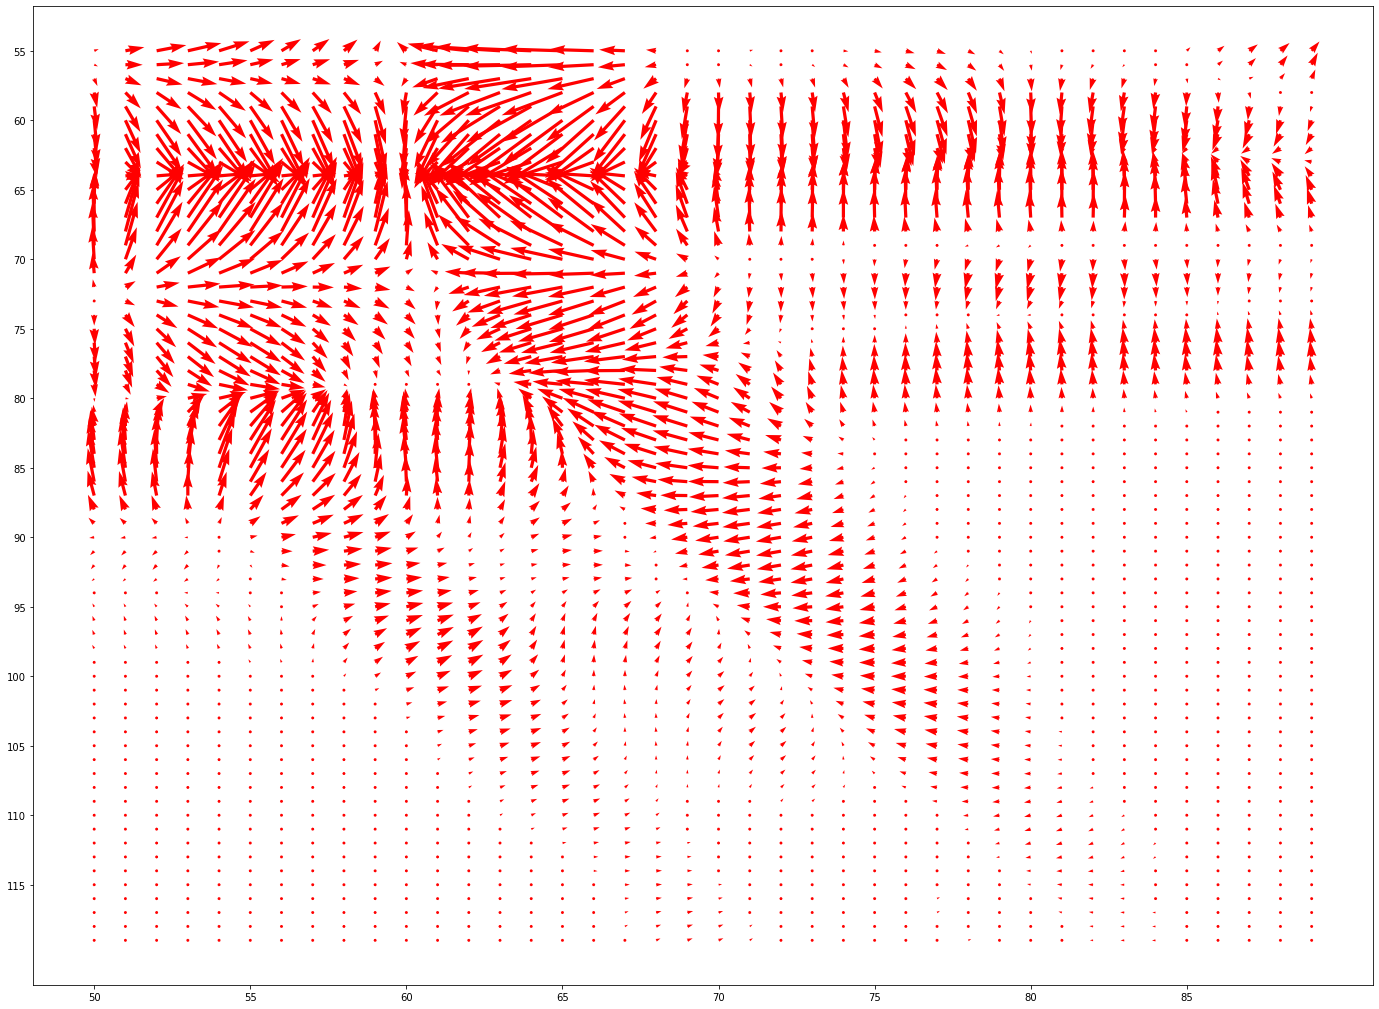

In [98]:
quiver_show_subset(u_total, v_total, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
plt.savefig(path.join(output_dir, "partial_image_over_time.png"))

#### Normalization.

##### Note: Doesn't work.

In [99]:
raise RuntimeError("Normalization doesn't work")

RuntimeError: Normalization doesn't work

In [ ]:
def normalize(u, v):
    beta_response = 1
    alpha_p = 0.1
    alpha_q = 0.002
    sigma_response = 3.6

    center = math.ceil(sigma_response * 3)
    size = center * 2 + 1

    filter_gaussian = cv2.getGaussianKernel(size, sigma_response)

    def relu(x):
        return x * (x > 0)

    uv_response = np.sqrt(u**2 + v**2)
    
    gaussian_response = cv2.filter2D(uv_response, -1, filter_gaussian)
    normalized_response = beta_response * uv_response / (alpha_p + uv_response + relu(gaussian_response / alpha_q))
    
    ratio = normalized_response / uv_response
    u_normalized = ratio * u
    v_normalized = ratio * v
    
    return u_normalized, v_normalized

In [ ]:
u_normalized, v_normalized = normalize(u, v)

In [ ]:
quiver_show_subset(u_normalized, v_normalized, 0, sensor_width, 0, sensor_height)
plt.savefig("whole_image_normalized.png")

In [ ]:
def normalize(u, v):
    beta_response = 1
    alpha_p = 0.1
    alpha_q = 0.002
    sigma_response = 3.6

    center = math.ceil(sigma_response * 3)
    size = center * 2 + 1

    filter_gaussian = cv2.getGaussianKernel(size, sigma_response)

    def relu(x):
        return x * (x > 0)

    uv_response = np.sqrt(u**2 + v**2)
    
    gaussian_response = cv2.filter2D(uv_response, -1, filter_gaussian)
    normalized_response = beta_response * uv_response / (alpha_p + uv_response + relu(gaussian_response / alpha_q))
    
    ratio = normalized_response / uv_response
    u_normalized = ratio * u
    v_normalized = ratio * v
    
    return u_normalized, v_normalized

# Issues

* It is not known whether spatial filter's scaling is correct.
* Combining response timeframes without normalization seems to be not effective.
* Gaussian time filters should be scalable.